## Import Competition Data

In [1]:
import numpy as np
import pandas as pd

property_df  = pd.read_csv("properties_2017.csv",low_memory = False)
train_df = pd.read_csv("train_2017.csv", parse_dates=["transactiondate"])

In [2]:
property_df.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2016.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,5.0,NaN,NaN,NaN,...,1.0,NaN,660680.0,1434941.0,2016.0,774261.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,6.0,NaN,NaN,...,1.0,NaN,580059.0,1174475.0,2016.0,594416.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,1.0,NaN,196751.0,440101.0,2016.0,243350.0,5725.17,NaN,NaN,NaN


In [3]:
train_df.head()

,parcelid,logerror,transactiondate
0,14297519,0.025595,2017-01-01
1,17052889,0.055619,2017-01-01
2,14186244,0.005383,2017-01-01
3,12177905,-0.103410,2017-01-01
4,10887214,0.006940,2017-01-01


## Data Cleaning

In [4]:
# find columns with missing values
missing_percent = property_df.isnull().sum() * 100 / len(property_df)
missing_values_df = pd.DataFrame({'column_name': property_df.columns, 'percent_missing': missing_percent})
print(missing_values_df[missing_values_df.percent_missing > 0].sort_values('percent_missing', ascending=False))

                                               column_name  percent_missing
storytypeid                                    storytypeid        99.945632
basementsqft                                  basementsqft        99.945498
yardbuildingsqft26                      yardbuildingsqft26        99.911363
fireplaceflag                                fireplaceflag        99.827048
architecturalstyletypeid          architecturalstyletypeid        99.796966
typeconstructiontypeid              typeconstructiontypeid        99.774020
finishedsquarefeet13                  finishedsquarefeet13        99.743034
buildingclasstypeid                    buildingclasstypeid        99.573532
pooltypeid10                                  pooltypeid10        99.430326
decktypeid                                      decktypeid        99.417831
finishedsquarefeet6                    finishedsquarefeet6        99.280387
poolsizesum                                    poolsizesum        99.063452
pooltypeid2 

In [5]:
# remove features with more than 80% null values
threshold = 80
null_cols = missing_values_df[missing_values_df.percent_missing > threshold].column_name.tolist()

In [6]:
property_df = property_df.drop(null_cols, axis=1)

In [7]:
property_df.shape

(2985217, 34)

In [8]:
# impute values for geographic categorical features - use mode of broader geographic feature by grouping
# using mode across the feature itself would provide geographical values that don't make sense
# eg: find most common zip code in the county to impute missing zip

def impute_geographical_feature(df, target_feature, group_feature):
    # mode of target feature grouped by the group geographic feature
    mode_per_group = df.groupby(group_feature)[target_feature].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)

    # impute missing values
    missing_mask = df[target_feature].isnull() & df[group_feature].notnull()
    df.loc[missing_mask, target_feature] = df.loc[missing_mask, group_feature].map(mode_per_group)

    # drop rows where group feature is missing or if target feature still missing after imputation
    df.dropna(subset=[target_feature, group_feature], inplace=True)

geographical_features = ['fips', 'regionidneighborhood', 'censustractandblock', 'rawcensustractandblock',\
                         'regionidzip', 'regionidcity', 'regionidcounty']
for feature in geographical_features:
    group_feature = 'regionidcounty' if feature != 'regionidcounty' or feature != 'fips' else 'regionidcity'
    impute_geographical_feature(property_df, feature, group_feature)

In [9]:
property_df.shape

(2982285, 34)

In [10]:
# impute categorical feature values
from sklearn.impute import SimpleImputer

cat_imputer = SimpleImputer(strategy='most_frequent') # use mode here as well

categorical_features = ['airconditioningtypeid', 'buildingqualitytypeid', 'heatingorsystemtypeid',
                        'propertycountylandusecode', 'propertylandusetypeid', 'propertyzoningdesc',
                        'regionidcity', 'regionidcounty', 'regionidzip', 'unitcnt',
                        'censustractandblock', 'rawcensustractandblock']

# impute missing values for each feature
for col in categorical_features:
    if col in property_df.columns:
        property_df[[col]] = cat_imputer.fit_transform(property_df[[col]])

In [11]:
# now do the same for the remaining numerical features

num_imputer = SimpleImputer(strategy='median')

numerical_features = ['basementsqft', 'bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid',
                      'calculatedbathnbr', 'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
                      'finishedsquarefeet12', 'finishedsquarefeet50', 'garagecarcnt', 'garagetotalsqft',
                      'latitude', 'longitude', 'lotsizesquarefeet', 'poolcnt', 'poolsizesum', 'roomcnt',
                      'threequarterbathnbr', 'unitcnt', 'yearbuilt', 'numberofstories',
                      'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'assessmentyear',
                      'landtaxvaluedollarcnt', 'taxamount', 'fullbathcnt']

for col in numerical_features:
    if col in property_df.columns:
        property_df[[col]] = num_imputer.fit_transform(property_df[[col]])

In [12]:
# confirm all missing values filled
print(property_df.isnull().sum())

parcelid                        0
airconditioningtypeid           0
bathroomcnt                     0
bedroomcnt                      0
buildingqualitytypeid           0
calculatedbathnbr               0
calculatedfinishedsquarefeet    0
finishedsquarefeet12            0
fips                            0
fullbathcnt                     0
garagecarcnt                    0
garagetotalsqft                 0
heatingorsystemtypeid           0
latitude                        0
longitude                       0
lotsizesquarefeet               0
propertycountylandusecode       0
propertylandusetypeid           0
propertyzoningdesc              0
rawcensustractandblock          0
regionidcity                    0
regionidcounty                  0
regionidneighborhood            0
regionidzip                     0
roomcnt                         0
unitcnt                         0
yearbuilt                       0
numberofstories                 0
structuretaxvaluedollarcnt      0
taxvaluedollar

### Combining Training Table

In [13]:
# pulling property data into training data
combined_df = train_df.merge(property_df, how='left', on='parcelid')
combined_df.head()

,parcelid,logerror,transactiondate,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,...,roomcnt,unitcnt,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock
0,14297519,0.025595,2017-01-01,1.0,3.5,4.0,6.0,3.5,3100.0,3100.0,...,0.0,1.0,1998.0,1.0,485713.0,1023282.0,2016.0,537569.0,11013.72,6.059063e+13
1,17052889,0.055619,2017-01-01,1.0,1.0,2.0,6.0,1.0,1465.0,1465.0,...,5.0,1.0,1967.0,1.0,88000.0,464000.0,2016.0,376000.0,5672.48,6.111001e+13
2,14186244,0.005383,2017-01-01,1.0,2.0,3.0,6.0,2.0,1243.0,1243.0,...,6.0,1.0,1962.0,1.0,85289.0,564778.0,2016.0,479489.0,6488.30,6.059022e+13
3,12177905,-0.103410,2017-01-01,1.0,3.0,4.0,8.0,3.0,2376.0,2376.0,...,0.0,1.0,1970.0,1.0,108918.0,145143.0,2016.0,36225.0,1777.51,6.037300e+13
4,10887214,0.006940,2017-01-01,1.0,3.0,3.0,8.0,3.0,1312.0,1312.0,...,0.0,1.0,1964.0,1.0,73681.0,119407.0,2016.0,45726.0,1533.89,6.037124e+13


In [14]:
# remove properties that were removed during data cleaning in the new combined DataFrame
final_property_features = [col for col in property_df.columns if col != 'parcelid']
# remove rows where all property features missing:
missing_property_data = combined_df[final_property_features].isnull().all(axis=1)
combined_df = combined_df[~missing_property_data]

In [15]:
combined_df.reset_index(drop=True, inplace=True)

## Dimensionality Reduction

In [16]:
# convert datetime columns to numerical format (to enable scaling)
for col in combined_df.select_dtypes(include=['datetime']):
    combined_df[f'{col}_year'] = combined_df[col].dt.year
    combined_df[f'{col}_month'] = combined_df[col].dt.month
    combined_df[f'{col}_day'] = combined_df[col].dt.day
    combined_df[f'{col}_weekday'] = combined_df[col].dt.weekday
    combined_df.drop(columns=[col], inplace=True)

In [17]:
combined_df.head()

,parcelid,logerror,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,transactiondate_year,transactiondate_month,transactiondate_day,transactiondate_weekday
0,14297519,0.025595,1.0,3.5,4.0,6.0,3.5,3100.0,3100.0,6059.0,...,485713.0,1023282.0,2016.0,537569.0,11013.72,6.059063e+13,2017,1,1,6
1,17052889,0.055619,1.0,1.0,2.0,6.0,1.0,1465.0,1465.0,6111.0,...,88000.0,464000.0,2016.0,376000.0,5672.48,6.111001e+13,2017,1,1,6
2,14186244,0.005383,1.0,2.0,3.0,6.0,2.0,1243.0,1243.0,6059.0,...,85289.0,564778.0,2016.0,479489.0,6488.30,6.059022e+13,2017,1,1,6
3,12177905,-0.103410,1.0,3.0,4.0,8.0,3.0,2376.0,2376.0,6037.0,...,108918.0,145143.0,2016.0,36225.0,1777.51,6.037300e+13,2017,1,1,6
4,10887214,0.006940,1.0,3.0,3.0,8.0,3.0,1312.0,1312.0,6037.0,...,73681.0,119407.0,2016.0,45726.0,1533.89,6.037124e+13,2017,1,1,6


In [18]:
# convert categorical to numerical for scaling as well
# using label encoding since one-hot encoding creates 2k+ features, which makes dim. red. infeasible
categorical_cols = combined_df.select_dtypes(include=['object']).columns

from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    combined_df[col] = le.fit_transform(combined_df[col])
    label_encoders[col] = le  # store to invert encoding later if needed

# NOTE: this can create an implied ordinal ordering - can change this if affecting linear model performance

In [19]:
# define levels: increasing number of components
# Baseline: 100% (no dimensionality reduction)
# Level 1: 10%
# Level 2: 50%
# Level 3: 75%

features_df = combined_df.drop(columns=['logerror'])
target = combined_df['logerror']

components_10 = int(features_df.shape[1] * 0.1)
components_50 = int(features_df.shape[1] * 0.5)
components_75 = int(features_df.shape[1] * 0.75)

print(features_df.shape)

(77579, 38)


In [20]:
combined_df.columns

Index(['parcelid', 'logerror', 'airconditioningtypeid', 'bathroomcnt',
       'bedroomcnt', 'buildingqualitytypeid', 'calculatedbathnbr',
       'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'fips',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'propertycountylandusecode', 'propertylandusetypeid',
       'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'unitcnt', 'yearbuilt', 'numberofstories', 'structuretaxvaluedollarcnt',
       'taxvaluedollarcnt', 'assessmentyear', 'landtaxvaluedollarcnt',
       'taxamount', 'censustractandblock', 'transactiondate_year',
       'transactiondate_month', 'transactiondate_day',
       'transactiondate_weekday'],
      dtype='object')

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_df)

In [22]:
# key metrics: run time, and data size (memory of dataframe)
# functions to measure these
import time
def measure_runtime(func):
    start_time = time.time()
    result = func()
    end_time = time.time()
    runtime = end_time - start_time
    return result, runtime

def dataframe_memory(df):
    return df.memory_usage(deep=True).sum()

### PCA

In [23]:
pca_results = {} # store new reduced datasets and metrics

In [24]:
from sklearn.decomposition import PCA
def apply_pca(n_components):
    pca = PCA(n_components=n_components)
    pca_result, runtime = measure_runtime(lambda: pca.fit_transform(features_scaled))
    reduced_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(n_components)])
    reduced_df['logerror'] = target
    mem_usage = dataframe_memory(reduced_df)
    return reduced_df, runtime, mem_usage

In [25]:
# Baseline - no reduction
baseline_runtime_start = time.time()
baseline_mem_usage = dataframe_memory(combined_df)
baseline_runtime = time.time() - baseline_runtime_start
pca_results['Baseline'] = (combined_df, baseline_runtime, baseline_mem_usage)

In [26]:
# PCA for 10%, 50%, 75%
for components, label in zip([components_10, components_50, components_75], ['10%', '50%', '75%']):
    reduced_df, runtime, mem_usage = apply_pca(components)
    pca_results[label] = (reduced_df, runtime, mem_usage)

In [27]:
# Output Results
for label, (df, runtime, mem_usage) in pca_results.items():
    print(f"Results for {label}:")
    print(f"Runtime: {runtime:.4f} seconds")
    print(f"Data Size: {mem_usage} bytes")
    print(f"DataFrame head:\n{df.head()}\n")

Results for Baseline:
Runtime: 0.0442 seconds
Data Size: 22963512 bytes
DataFrame head:
   parcelid  logerror  airconditioningtypeid  bathroomcnt  bedroomcnt  \
0  14297519  0.025595                    1.0          3.5         4.0   
1  17052889  0.055619                    1.0          1.0         2.0   
2  14186244  0.005383                    1.0          2.0         3.0   
3  12177905 -0.103410                    1.0          3.0         4.0   
4  10887214  0.006940                    1.0          3.0         3.0   

   buildingqualitytypeid  calculatedbathnbr  calculatedfinishedsquarefeet  \
0                    6.0                3.5                        3100.0   
1                    6.0                1.0                        1465.0   
2                    6.0                2.0                        1243.0   
3                    8.0                3.0                        2376.0   
4                    8.0                3.0                        1312.0   

   finishe

In [28]:
pca_results['10%'][0].to_csv('pca_10.csv', index=False)
pca_results['50%'][0].to_csv('pca_50.csv', index=False)
pca_results['75%'][0].to_csv('pca_75.csv', index=False)

### UMAP

In [31]:
umap_results = {}

In [ ]:
#!pip3 install umap-learn
import umap.umap_ as umap

def find_ideal_n_neighbors(components_list, features_scaled):
    avg_silhouette_scores = {}
    for n_neighbors in range(5, 21, 5):
        silhouette_scores = []
        for components in components_list:
            umap_model = umap.UMAP(n_neighbors=n_neighbors, n_components=components)
            umap_result = umap_model.fit_transform(features_scaled)
            silhouette_score = silhouette_score_umap(umap_result)
            silhouette_scores.append(silhouette_score)
        avg_silhouette_scores[n_neighbors] = np.mean(silhouette_scores)
    ideal_n_neighbors = max(avg_silhouette_scores, key=avg_silhouette_scores.get)
    return ideal_n_neighbors

In [35]:
from sklearn.metrics import silhouette_samples
def silhouette_score_umap(embedding):
    silhouette_vals = silhouette_samples(embedding, target)
    return np.mean(silhouette_vals)

In [36]:
def apply_umap(n_components, n_neighbors):
    umap_model = umap.UMAP(n_components=n_components, n_neighbors=n_neighbors)
    umap_result, runtime = measure_runtime(lambda: umap_model.fit_transform(features_scaled))
    reduced_df = pd.DataFrame(umap_result, columns=[f'UMAP_{i+1}' for i in range(n_components)])
    reduced_df['logerror'] = target
    mem_usage = reduced_df.memory_usage(deep=True).sum()
    return reduced_df, runtime, mem_usage

In [37]:
# ideal_n_neighbors = find_ideal_n_neighbors([components_10, components_50, components_75], features_scaled)
# print(ideal_n_neighbors)
# Found that ideal_n_neighbors = 10
ideal_n_neighbors = 10

In [38]:
# UMAP for 10%, 50%, 75%
for components, label in zip([components_10, components_50, components_75], ['10%', '50%', '75%']):
    reduced_df, runtime, mem_usage = apply_umap(components, ideal_n_neighbors)
    umap_results[label] = (reduced_df, runtime, mem_usage)

In [39]:
# Output Results
for label, (df, runtime, mem_usage) in umap_results.items():
    print(f"Results for {label}:")
    print(f"Runtime: {runtime:.4f} seconds")
    print(f"Data Size: {mem_usage} bytes")
    print(f"DataFrame head:\n{df.head()}\n")

Results for 10%:
Runtime: 167.7662 seconds
Data Size: 1551708 bytes
DataFrame head:
      UMAP_1    UMAP_2     UMAP_3  logerror
0   1.866583  6.368548  -0.119727  0.025595
1   6.433016  5.097232  14.225377  0.055619
2   2.819944  5.664339   4.158367  0.005383
3   7.907321 -5.253650   6.709470 -0.103410
4  14.462445  0.837626   4.968976  0.006940

Results for 50%:
Runtime: 156.9764 seconds
Data Size: 6516764 bytes
DataFrame head:
      UMAP_1    UMAP_2    UMAP_3    UMAP_4    UMAP_5    UMAP_6    UMAP_7  \
0   6.797142  6.698859  6.416568  4.108078  5.850289  7.864512  5.498840   
1   7.992028  3.621163  5.257889  4.084964  5.501478  5.880675  1.124054   
2   7.706748  5.853842  5.886187  4.293502  5.262532  7.170082  5.012338   
3   9.639996  4.687711  5.273234 -4.409168  5.054744  4.911519  4.789576   
4  12.370427  3.714681  4.942852  4.543063  5.169371  5.366427  4.335492   

     UMAP_8    UMAP_9   UMAP_10   UMAP_11   UMAP_12   UMAP_13   UMAP_14  \
0  5.330845  9.338297  3.828122  5.

In [40]:
umap_results['10%'][0].to_csv('umap_10.csv', index=False)
umap_results['50%'][0].to_csv('umap_50.csv', index=False)
umap_results['75%'][0].to_csv('umap_75.csv', index=False)

### Autoencoder

In [42]:
autoencoder_results = {}

In [43]:
import tensorflow as tf
def autoencoder_dimension_reduction(dataset, n_dimensions):
    input_dim = dataset.shape[1]
    encoding_dim = n_dimensions

    input_data = tf.keras.layers.Input(shape=(input_dim,))
    encoded = tf.keras.layers.Dense(encoding_dim, activation='relu')(input_data)
    decoded = tf.keras.layers.Dense(input_dim, activation='sigmoid')(encoded)

    autoencoder = tf.keras.models.Model(input_data, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

    autoencoder.fit(dataset, dataset, epochs=50, batch_size=256, shuffle=True, validation_split=0.2)

    encoder = tf.keras.models.Model(input_data, encoded)
    reduced_dataset = encoder.predict(dataset)
    return reduced_dataset


In [44]:
def apply_autoencoder(n_components):
    autoencoder_result, runtime = measure_runtime(lambda: autoencoder_dimension_reduction(features_scaled, n_components))
    reduced_df = pd.DataFrame(autoencoder_result, columns=[f'AE_{i+1}' for i in range(n_components)])
    reduced_df['logerror'] = target
    mem_usage = reduced_df.memory_usage(deep=True).sum()
    return reduced_df, runtime, mem_usage

In [45]:
# Autoencoder for 10%, 50%, 75%
for components, label in zip([components_10, components_50, components_75], ['10%', '50%', '75%']):
    reduced_df, runtime, mem_usage = apply_autoencoder(components)
    autoencoder_results[label] = (reduced_df, runtime, mem_usage)

Epoch 1/50
243/243 [==============================] - 2s 3ms/step - loss: 0.4278 - val_loss: 0.1794
Epoch 2/50
243/243 [==============================] - 1s 2ms/step - loss: -0.5929 - val_loss: -0.9027
Epoch 3/50
243/243 [==============================] - 1s 2ms/step - loss: -2.5453 - val_loss: -2.7472
Epoch 4/50
243/243 [==============================] - 1s 2ms/step - loss: -5.6391 - val_loss: -5.4003
Epoch 5/50
243/243 [==============================] - 1s 2ms/step - loss: -9.8493 - val_loss: -8.8139
Epoch 6/50
243/243 [==============================] - 1s 2ms/step - loss: -15.0831 - val_loss: -12.9287
Epoch 7/50
243/243 [==============================] - 1s 2ms/step - loss: -21.2570 - val_loss: -17.6811
Epoch 8/50
243/243 [==============================] - 1s 2ms/step - loss: -28.2944 - val_loss: -23.0237
Epoch 9/50
243/243 [==============================] - 1s 2ms/step - loss: -36.1379 - val_loss: -28.9256
Epoch 10/50
243/243 [==============================] - 1s 2ms/step - loss: -

In [46]:
# Output Results
for label, (df, runtime, mem_usage) in autoencoder_results.items():
    print(f"Results for {label}:")
    print(f"Runtime: {runtime:.4f} seconds")
    print(f"Data Size: {mem_usage} bytes")
    print(f"DataFrame head:\n{df.head()}\n")

Results for 10%:
Runtime: 47.6446 seconds
Data Size: 1551708 bytes
DataFrame head:
        AE_1        AE_2        AE_3  logerror
0   0.000000    0.000000    0.000000  0.025595
1   0.000000    0.000000    0.000000  0.055619
2   0.000000    0.000000    0.000000  0.005383
3  83.916260  146.320084  124.779823 -0.103410
4  65.488441  137.818024  132.294083  0.006940

Results for 50%:
Runtime: 45.9359 seconds
Data Size: 6516764 bytes
DataFrame head:
         AE_1        AE_2        AE_3        AE_4       AE_5        AE_6  \
0    0.000000    0.000000   86.907143    0.000000   0.000000    0.000000   
1    0.000000    0.000000    0.000000  106.671730   0.000000    0.000000   
2    0.000000   14.244525    0.000000  109.860809   0.000000    0.000000   
3   43.972336  189.814346   73.522232    1.135750   8.106716  151.122849   
4  104.511940  149.870697  142.554962    0.000000  74.722382  144.182144   

         AE_7        AE_8        AE_9       AE_10       AE_11       AE_12  \
0    0.000000    

In [47]:
autoencoder_results['10%'][0].to_csv('autoencoder_10.csv', index=False)
autoencoder_results['50%'][0].to_csv('autoencoder_50.csv', index=False)
autoencoder_results['75%'][0].to_csv('autoencoder_75.csv', index=False)

### Kernel PCA

In [49]:
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import KernelPCA

class IncrementalKernelPCA:
    def __init__(self, kpca, n_components=None):
        self.kpca = kpca
        self.n_components = n_components
        self.ipca = IncrementalPCA(n_components=self.n_components)

    def fit(self, X):
        # First fit to initialize the rbfsampler with the first batch of data
        transformed = self.kpca.fit_transform(X)
        self.ipca.fit(transformed)

    def partial_fit(self, X):
        # Transform the data with the already fitted rbfsampler and partially fit the PCA
        transformed = self.kpca.transform(X)
        self.ipca.partial_fit(transformed)

    def fit_in_batches(self, X, n_batches=50):
        # Split data into batches
        batches = np.array_split(X, n_batches)

        # Fit the first batch to setup
        self.fit(batches[0])

        # Fit the rest incrementally
        for batch in batches[1:]:
            self.partial_fit(batch)

    def transform(self, X):
        # Transform the data with the already fitted rbfsampler and apply PCA transformation
        transformed = self.kpca.transform(X)
        return self.ipca.transform(transformed)

In [50]:
def apply_ikpca(kpca, n_components):
    # Initialize the Incremental Kernel PCA
    ikpca = IncrementalKernelPCA(kpca, n_components=n_components)

    # Calculate number of batches
    n_points = features_scaled.shape[0]
    batch_size = 1000
    n_batches = n_points / batch_size

    # Function to fit and transform data using the Incremental Kernel PCA
    def fit_incrementally_and_transform():
        ikpca.fit_in_batches(features_scaled, n_batches=n_batches)
        return ikpca.transform(features_scaled)

    # Time the function
    ikpca_result, runtime = measure_runtime(lambda: fit_incrementally_and_transform())

    # Calculate final values and return
    reduced_df = pd.DataFrame(ikpca_result, columns=[f'PC{i+1}' for i in range(n_components)])
    reduced_df['logerror'] = target
    mem_usage = dataframe_memory(reduced_df)
    return reduced_df, runtime, mem_usage

In [51]:
# CHANGE THE TYPE OF KERNEL HERE:
kernel_pca = KernelPCA(gamma=1, kernel='poly', degree=2)

In [52]:
# Initialize results
ikpca_results = {}

# Incremental Kernel PCA for 10%, 50%, 75%
for components, label in zip([components_10, components_50, components_75], ['10%', '50%', '75%']):
    reduced_df, runtime, mem_usage = apply_ikpca(kernel_pca, components)
    ikpca_results[label] = (reduced_df, runtime, mem_usage)

In [53]:
# Output Results
for label, (df, runtime, mem_usage) in ikpca_results.items():
    print(f"Results for {label}:")
    print(f"Runtime: {runtime:.4f} seconds")
    print(f"Data Size: {mem_usage} bytes")
    print(f"DataFrame head:\n{df.head()}\n")

Results for 10%:
Runtime: 40.7807 seconds
Data Size: 2482656 bytes
DataFrame head:
        PC1       PC2       PC3  logerror
0  1.079212 -0.429195 -0.917538  0.025595
1  1.082180 -4.019133 -0.978306  0.055619
2  1.079663 -4.402646 -0.949426  0.005383
3  1.069355 -4.263007 -0.962398 -0.103410
4  1.066845 -3.857770 -0.966024  0.006940

Results for 50%:
Runtime: 33.9779 seconds
Data Size: 12412768 bytes
DataFrame head:
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  1.080704 -0.382906 -0.919684  0.590542 -1.015309 -3.718853 -1.186895   
1  1.081736 -4.038409 -0.979335 -0.201582 -1.085069  1.462280 -1.108841   
2  1.079214 -4.438882 -0.949426  1.076632 -0.946497  3.192375 -1.001290   
3  1.068557 -4.301123 -0.962184  1.107070 -1.015683  3.410574 -0.862145   
4  1.065921 -3.895982 -0.965569  0.793181  4.148510  3.232659 -0.207737   

        PC8        PC9       PC10      PC11      PC12       PC13       PC14  \
0 -5.913266  -0.995336   1.027823 -0.123948 -3.708

In [54]:
ikpca_results['10%'][0].to_csv('ikpca_10.csv', index=False)
ikpca_results['50%'][0].to_csv('ikpca_50.csv', index=False)
ikpca_results['75%'][0].to_csv('ikpca_75.csv', index=False)

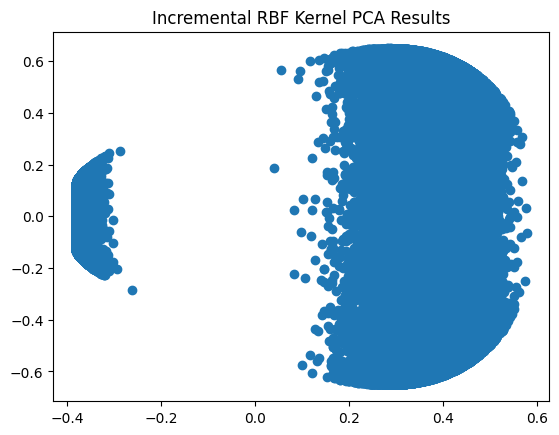

In [ ]:
# This was just for learning

import numpy as np
from sklearn.decomposition import IncrementalPCA
from sklearn.kernel_approximation import RBFSampler

class IncrementalRBFPca:
    def __init__(self, n_components=2, gamma=0.1, n_samples=100):
        self.n_components = n_components
        self.gamma = gamma
        self.n_samples = n_samples
        self.rbfsampler = KernelPCA(gamma=self.gamma, n_components=self.n_samples, kernel='rbf')
        self.pca = IncrementalPCA(n_components=self.n_components)

    def fit(self, X):
        # First fit to initialize the rbfsampler with the first batch of data
        transformed = self.rbfsampler.fit_transform(X)
        self.pca.fit(transformed)

    def partial_fit(self, X):
        # Transform the data with the already fitted rbfsampler and partially fit the PCA
        transformed = self.rbfsampler.transform(X)
        self.pca.partial_fit(transformed)

    def transform(self, X):
        # Transform the data with the already fitted rbfsampler and apply PCA transformation
        transformed = self.rbfsampler.transform(X)
        return self.pca.transform(transformed)

# Example usage:
if __name__ == "__main__":
    from sklearn.datasets import make_circles

    # Create a dataset
    n_points = 80000
    batch_size = 2000
    n_batches = n_points / batch_size
    X, _ = make_circles(n_samples=n_points, factor=.3, noise=.05)

    # Initialize the Incremental RBF PCA
    inc_rbf_pca = IncrementalRBFPca(n_components=None, gamma=5, n_samples=int(batch_size/3))

    # Simulate incoming data in batches
    batches = np.array_split(X, n_batches)  # Split data into 5 batches

    # Fit the first batch to setup
    inc_rbf_pca.fit(batches[0])

    # Fit the rest incrementally
    for batch in batches[1:]:
        inc_rbf_pca.partial_fit(batch)

    # Transform data using the incrementally learned PCA
    X_transformed = inc_rbf_pca.transform(X)

    # For visualization
    import matplotlib.pyplot as plt
    plt.scatter(X_transformed[:, 0], X_transformed[:, 1])
    plt.title('Incremental RBF Kernel PCA Results')
    plt.show()